In [2]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [3]:
def find_upper_bound(mu, std, alpha=0.95):
    z_value = norm.ppf(alpha)
    return mu + std * z_value

def find_optimal_std_lstm(train, confidence, train_win):
    """
    conf_levels = list of confidence level e.g. np.arange(0.90, 1, 0.01) from which you want to find the optimal std
    train_win: int, lenght of the past history used for finding the optimal standard deviation
    """
    stds_test = np.arange(0.01, 1., 0.0005) # this range needs to be set for ali2020
    train_d = None
    if train_win:
        train_d = train.iloc[-train_win:].copy()
    for std in stds_test:
        train_d["up"] = train_d.apply(lambda row: find_upper_bound(row["avggpu"], std, confidence), axis=1)
        # count how much you under predict
        up = sum(train_d.up < train_d.labels)/len(train_d)*100
        count_perc = 100. - up
        if count_perc >= confidence:
            return std
    return None

In [4]:
gpu_conv_value = 0.00021648585046
gpu_no_norm_conv_value = 6958.933333333333333
per_unit_energy_cons = 1
target_qos = ["90", "91", "92", "93", "94", "95", "96", "97", "98", "99"]

In [5]:
original_dataset = pd.read_csv("../saved_data/ali20/ali20_g.csv")
scaler = MinMaxScaler()
factor=0.8
scaler.fit(original_dataset.avggpu.iloc[:int(original_dataset.shape[0]*factor)].values.reshape(-1,1))
original_dataset.describe()

,Unnamed: 0,time,avggpu,avggpumem
count,14358.000000,1.435800e+04,1.435800e+04,1.435800e+04
mean,8928.500000,1.596240e+09,2.062431e+07,3.858848e+06
std,4144.941918,1.243483e+06,4.407054e+06,9.409406e+05
min,1750.000000,1.594087e+09,6.682396e+06,1.223004e+06
25%,5339.250000,1.595163e+09,1.780858e+07,3.268815e+06
50%,8928.500000,1.596240e+09,2.088287e+07,3.882400e+06
75%,12517.750000,1.597317e+09,2.357788e+07,4.509566e+06
max,16107.000000,1.598394e+09,3.368392e+07,6.902691e+06


In [6]:
hbnn_results = pd.read_csv("output_HBNN-ali20_g-gpu-w288-h2.csv")
hbnn_results.drop(labels=["Unnamed: 0"], inplace=True, axis=1)
hbnn_results["model"] = ["HBNN" for i in range(len(hbnn_results))]
hbnn_results.rename(columns={"avggpu": "pred_norm_gpu", "std": "pred_std", "labels": "true_norm_gpu"}, inplace=True)
first_column = hbnn_results.pop('model')
hbnn_results.insert(0, 'model', first_column)
hbnn_results["true_gpu"] = scaler.inverse_transform(hbnn_results["true_norm_gpu"].values.reshape(-1,1))
hbnn_results["true_n_gpu"] = hbnn_results.apply(lambda row: math.ceil(row["true_gpu"]/gpu_no_norm_conv_value), axis=1)
hbnn_results["pred_gpu"] = scaler.inverse_transform(hbnn_results["pred_norm_gpu"].values.reshape(-1,1))
for target in target_qos:
    alpa = float(int(target)/100)
    hbnn_results[f"ub_{target}_norm"] = hbnn_results.apply(lambda row: find_upper_bound(row["pred_norm_gpu"], row["pred_std"], alpha=alpa), axis=1)
    hbnn_results[f"ub_{target}"] = scaler.inverse_transform(hbnn_results[f"ub_{target}_norm"].values.reshape(-1,1))
    hbnn_results[f"pred_n_gpu_{target}"] = hbnn_results.apply(lambda row: math.ceil(row[f"ub_{target}"]/gpu_no_norm_conv_value), axis=1)
hbnn_results.to_csv("scenarios/hbnn_results.csv")
hbnn_results.describe()

,pred_norm_gpu,pred_std,true_norm_gpu,true_gpu,true_n_gpu,pred_gpu,ub_90_norm,ub_90,pred_n_gpu_90,ub_91_norm,...,pred_n_gpu_96,ub_97_norm,ub_97,pred_n_gpu_97,ub_98_norm,ub_98,pred_n_gpu_98,ub_99_norm,ub_99,pred_n_gpu_99
count,2582.000000,2582.000000,2582.000000,2.582000e+03,2582.000000,2.582000e+03,2582.000000,2.582000e+03,2582.000000,2582.000000,...,2582.000000,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,2582.000000
mean,0.357420,0.049786,0.328949,1.772129e+07,2547.051123,1.833324e+07,0.421223,1.970464e+07,2832.052672,0.424171,...,2904.207204,0.451057,2.034590e+07,2924.202556,0.459668,2.053098e+07,2950.803641,0.473239,2.082269e+07,2992.729280
std,0.187234,0.007063,0.232520,4.997830e+06,718.189507,4.024433e+06,0.188831,4.058763e+06,583.245436,0.188915,...,585.367004,0.189721,4.077902e+06,586.005779,0.189995,4.083786e+06,586.841574,0.190441,4.093385e+06,588.223474
min,0.109442,0.016079,-0.172291,6.947540e+06,999.000000,1.300316e+07,0.167206,1.424474e+07,2047.000000,0.169874,...,2113.000000,0.194216,1.482530e+07,2131.000000,0.202011,1.499286e+07,2155.000000,0.214298,1.525696e+07,2193.000000
25%,0.143482,0.046260,0.106536,1.294070e+07,1860.000000,1.373481e+07,0.210610,1.517768e+07,2181.500000,0.213763,...,2260.000000,0.242669,1.586675e+07,2280.500000,0.251706,1.606100e+07,2308.250000,0.265869,1.636542e+07,2352.000000
50%,0.372455,0.049210,0.362540,1.844329e+07,2651.000000,1.865642e+07,0.433462,1.996770e+07,2869.500000,0.436478,...,2933.000000,0.460769,2.055465e+07,2954.500000,0.468404,2.071875e+07,2977.500000,0.481697,2.100448e+07,3019.000000
75%,0.516378,0.052960,0.519670,2.182068e+07,3136.000000,2.174992e+07,0.581171,2.314260e+07,3325.750000,0.584130,...,3398.000000,0.611112,2.378614e+07,3419.000000,0.619926,2.397560e+07,3445.750000,0.633787,2.427352e+07,3488.500000
max,0.825197,0.110551,0.915283,3.032405e+07,4358.000000,2.838773e+07,0.898194,2.995674e+07,4305.000000,0.901566,...,4388.000000,0.932327,3.069040e+07,4411.000000,0.942178,3.090215e+07,4441.000000,0.957705,3.123589e+07,4489.000000


In [7]:
max(hbnn_results["true_gpu"].values)/43916358.2147171

0.6904956366897531

In [8]:
monte_results = pd.read_csv("output_MCDLSTM-ali20_g-gpu-w288-h2.csv")
monte_results.drop(labels=["Unnamed: 0"], inplace=True, axis=1)
monte_results["model"] = ["MCD" for i in range(len(monte_results))]
monte_results.rename(columns={"avggpu": "pred_norm_gpu", "std": "pred_std", "labels": "true_norm_gpu"}, inplace=True)
first_column = monte_results.pop('model')
monte_results.insert(0, 'model', first_column)
monte_results["true_gpu"] = scaler.inverse_transform(monte_results["true_norm_gpu"].values.reshape(-1,1))
monte_results["true_n_gpu"] = monte_results.apply(lambda row: math.ceil(row["true_gpu"]/gpu_no_norm_conv_value), axis=1)
# monte_results.drop(columns=['true_norm_gpu'], inplace=True)
monte_results["pred_gpu"] = scaler.inverse_transform(monte_results["pred_norm_gpu"].values.reshape(-1,1))

for target in target_qos:
    alpa = float(int(target)/100)
    monte_results[f"ub_{target}_norm"] = monte_results.apply(lambda row: find_upper_bound(row["pred_norm_gpu"], row["pred_std"], alpha=alpa), axis=1)
    monte_results[f"ub_{target}"] = scaler.inverse_transform(monte_results[f"ub_{target}_norm"].values.reshape(-1,1))
    monte_results[f"pred_n_gpu_{target}"] = monte_results.apply(lambda row: math.ceil(row[f"ub_{target}"]/gpu_no_norm_conv_value), axis=1)
monte_results.to_csv("scenarios/monte_results.csv")
monte_results.describe()

,pred_norm_gpu,pred_std,true_norm_gpu,true_gpu,true_n_gpu,pred_gpu,ub_90_norm,ub_90,pred_n_gpu_90,ub_91_norm,...,pred_n_gpu_96,ub_97_norm,ub_97,pred_n_gpu_97,ub_98_norm,ub_98,pred_n_gpu_98,ub_99_norm,ub_99,pred_n_gpu_99
count,2582.000000,2.582000e+03,2582.000000,2.582000e+03,2582.000000,2.582000e+03,2582.000000,2.582000e+03,2582.000000,2582.000000,...,2582.000000,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,2582.000000
mean,0.337572,6.597421e-08,0.328949,1.772129e+07,2547.051123,1.790663e+07,0.337572,1.790664e+07,2573.692874,0.337572,...,2573.692874,0.337572,1.790664e+07,2573.692874,0.337573,1.790664e+07,2573.693261,0.337573,1.790664e+07,2573.693261
std,0.214559,6.558250e-08,0.232520,4.997830e+06,718.189507,4.611775e+06,0.214559,4.611776e+06,662.714245,0.214559,...,662.714245,0.214559,4.611777e+06,662.714245,0.214559,4.611777e+06,662.713676,0.214559,4.611777e+06,662.713676
min,-0.039172,0.000000e+00,-0.172291,6.947540e+06,999.000000,9.808823e+06,-0.039172,9.808824e+06,1410.000000,-0.039172,...,1410.000000,-0.039172,9.808824e+06,1410.000000,-0.039172,9.808824e+06,1410.000000,-0.039172,9.808824e+06,1410.000000
25%,0.125868,1.117587e-08,0.106536,1.294070e+07,1860.000000,1.335623e+07,0.125868,1.335623e+07,1919.500000,0.125868,...,1919.500000,0.125868,1.335623e+07,1919.500000,0.125868,1.335623e+07,1919.500000,0.125868,1.335623e+07,1919.500000
50%,0.367512,5.960465e-08,0.362540,1.844329e+07,2651.000000,1.855016e+07,0.367512,1.855016e+07,2666.000000,0.367512,...,2666.000000,0.367512,1.855016e+07,2666.000000,0.367512,1.855016e+07,2666.000000,0.367512,1.855016e+07,2666.000000
75%,0.512203,8.940697e-08,0.519670,2.182068e+07,3136.000000,2.166017e+07,0.512203,2.166018e+07,3112.750000,0.512203,...,3112.750000,0.512203,2.166018e+07,3112.750000,0.512203,2.166018e+07,3112.750000,0.512203,2.166018e+07,3112.750000
max,0.893295,2.980232e-07,0.915283,3.032405e+07,4358.000000,2.985144e+07,0.893295,2.985145e+07,4290.000000,0.893295,...,4290.000000,0.893295,2.985145e+07,4290.000000,0.893295,2.985145e+07,4290.000000,0.893295,2.985145e+07,4290.000000


In [9]:
flbnn_results = pd.read_csv("output_FLBNN-ali20_g-gpu-w288-h2.csv")
flbnn_results.drop(labels=["Unnamed: 0"], inplace=True, axis=1)
flbnn_results["model"] = ["HBNN++" for i in range(len(flbnn_results))]
flbnn_results.rename(columns={"avggpu": "pred_norm_gpu", "std": "pred_std", "labels": "true_norm_gpu"}, inplace=True)
first_column = flbnn_results.pop('model')
flbnn_results.insert(0, 'model', first_column)
flbnn_results["true_gpu"] = scaler.inverse_transform(flbnn_results["true_norm_gpu"].values.reshape(-1,1))
flbnn_results["true_n_gpu"] = flbnn_results.apply(lambda row: math.ceil(row["true_gpu"]/gpu_no_norm_conv_value), axis=1)
# flbnn_results.drop(columns=['true_norm_gpu'], inplace=True)
flbnn_results["pred_gpu"] = scaler.inverse_transform(flbnn_results["pred_norm_gpu"].values.reshape(-1,1))

for target in target_qos:
    alpa = float(int(target)/100)
    flbnn_results[f"ub_{target}_norm"] = flbnn_results.apply(lambda row: find_upper_bound(row["pred_norm_gpu"], row["pred_std"], alpha=alpa), axis=1)
    flbnn_results[f"ub_{target}"] = scaler.inverse_transform(flbnn_results[f"ub_{target}_norm"].values.reshape(-1,1))
    flbnn_results[f"pred_n_gpu_{target}"] = flbnn_results.apply(lambda row: math.ceil(row[f"ub_{target}"]/gpu_no_norm_conv_value), axis=1)
flbnn_results.to_csv("scenarios/flbnn_results.csv")
flbnn_results.describe()

,pred_norm_gpu,pred_std,true_norm_gpu,true_gpu,true_n_gpu,pred_gpu,ub_90_norm,ub_90,pred_n_gpu_90,ub_91_norm,...,pred_n_gpu_96,ub_97_norm,ub_97,pred_n_gpu_97,ub_98_norm,ub_98,pred_n_gpu_98,ub_99_norm,ub_99,pred_n_gpu_99
count,2582.000000,2582.000000,2582.000000,2.582000e+03,2582.000000,2.582000e+03,2582.000000,2.582000e+03,2582.000000,2582.000000,...,2582.000000,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,2582.000000
mean,0.362692,0.066016,0.328949,1.772129e+07,2547.051123,1.844655e+07,0.447295,2.026503e+07,2912.587529,0.451203,...,3008.252905,0.486855,2.111534e+07,3034.780790,0.498273,2.136076e+07,3070.043377,0.516269,2.174757e+07,3125.620837
std,0.160845,0.010062,0.232520,4.997830e+06,718.189507,3.457235e+06,0.172483,3.707383e+06,532.743167,0.173025,...,546.049709,0.177984,3.825629e+06,549.741435,0.179578,3.859893e+06,554.664675,0.182096,3.914014e+06,562.443335
min,0.128860,0.043463,-0.172291,6.947540e+06,999.000000,1.342052e+07,0.198997,1.492808e+07,2146.000000,0.202238,...,2225.000000,0.231793,1.563300e+07,2247.000000,0.241259,1.583645e+07,2276.000000,0.256178,1.615713e+07,2322.000000
25%,0.163772,0.053720,0.106536,1.294070e+07,1860.000000,1.417095e+07,0.230023,1.559494e+07,2241.250000,0.233086,...,2316.250000,0.261072,1.626231e+07,2337.250000,0.270133,1.645707e+07,2365.250000,0.284297,1.676152e+07,2409.000000
50%,0.404047,0.070484,0.362540,1.844329e+07,2651.000000,1.933546e+07,0.496730,2.132760e+07,3065.000000,0.500986,...,3169.500000,0.539615,2.224938e+07,3198.000000,0.551925,2.251397e+07,3236.000000,0.571510,2.293493e+07,3296.500000
75%,0.510996,0.074996,0.519670,2.182068e+07,3136.000000,2.163423e+07,0.608714,2.373460e+07,3411.000000,0.613219,...,3522.000000,0.654395,2.471648e+07,3552.000000,0.667527,2.499874e+07,3593.000000,0.688476,2.544902e+07,3657.750000
max,0.619214,0.090434,0.915283,3.032405e+07,4358.000000,2.396029e+07,0.699979,2.569626e+07,3693.000000,0.703710,...,3784.000000,0.737744,2.650799e+07,3810.000000,0.748643,2.674227e+07,3843.000000,0.765823,2.711153e+07,3896.000000


In [10]:
lstmq_results = pd.read_csv("LSTMQ/output_LSTMQ-0.95-ali20_g-gpu-w288-h2.csv")
lstmq_results.drop(labels=["Unnamed: 0"], inplace=True, axis=1)
lstmq_results["model"] = ["LSTMQ" for i in range(len(lstmq_results))]
lstmq_results.rename(columns={"avggpu": "pred_norm_gpu", "std": "pred_std", "labels": "true_norm_gpu"}, inplace=True)
first_column = lstmq_results.pop('model')
lstmq_results.insert(0, 'model', first_column)
lstmq_results["true_gpu"] = scaler.inverse_transform(lstmq_results["true_norm_gpu"].values.reshape(-1,1))
lstmq_results["true_n_gpu"] = lstmq_results.apply(lambda row: math.ceil(row["true_gpu"]/gpu_no_norm_conv_value), axis=1)
# lstmq_results.drop(columns=['true_norm_gpu'], inplace=True)

for target in target_qos:
    alpa = float(int(target)/100)
    target_results = pd.read_csv(f"LSTMQ/output_LSTMQ-{alpa}-ali20_g-gpu-w288-h2.csv")
    lstmq_results[f"ub_{target}_norm"] = target_results.apply(lambda row: find_upper_bound(row["avggpu"], row["std"], alpha=alpa), axis=1)
    lstmq_results[f"ub_{target}"] = scaler.inverse_transform(lstmq_results[f"ub_{target}_norm"].values.reshape(-1,1))
    lstmq_results[f"pred_n_gpu_{target}"] = lstmq_results.apply(lambda row: math.ceil(row[f"ub_{target}"]/gpu_no_norm_conv_value), axis=1)
lstmq_results.to_csv("scenarios/lstmq_results.csv")
lstmq_results.describe()

,pred_norm_gpu,pred_std,true_norm_gpu,true_gpu,true_n_gpu,ub_90_norm,ub_90,pred_n_gpu_90,ub_91_norm,ub_91,...,pred_n_gpu_96,ub_97_norm,ub_97,pred_n_gpu_97,ub_98_norm,ub_98,pred_n_gpu_98,ub_99_norm,ub_99,pred_n_gpu_99
count,2582.000000,2582.0,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,...,2582.000000,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,2582.000000
mean,0.401227,0.0,0.328949,1.772129e+07,2547.051123,0.365301,1.850264e+07,2659.324555,0.379118,1.879962e+07,...,2810.230054,0.410383,1.947165e+07,2798.585980,0.449391,2.031008e+07,2919.060031,0.504672,2.149830e+07,3089.815647
std,0.227837,0.0,0.232520,4.997830e+06,718.189507,0.227710,4.894433e+06,703.334291,0.229850,4.940434e+06,...,678.332355,0.200764,4.315268e+06,620.102623,0.205721,4.421812e+06,635.423755,0.203512,4.374329e+06,628.588877
min,0.005820,0.0,-0.172291,6.947540e+06,999.000000,-0.044874,9.686262e+06,1392.000000,-0.011003,1.041430e+07,...,1711.000000,0.065909,1.206745e+07,1735.000000,0.089352,1.257133e+07,1807.000000,0.136283,1.358009e+07,1952.000000
25%,0.190937,0.0,0.106536,1.294070e+07,1860.000000,0.147834,1.382836e+07,1988.000000,0.155301,1.398885e+07,...,2146.500000,0.223268,1.544976e+07,2220.250000,0.256659,1.616747e+07,2324.000000,0.317426,1.747360e+07,2511.500000
50%,0.431730,0.0,0.362540,1.844329e+07,2651.000000,0.398979,1.922653e+07,2763.000000,0.411144,1.948800e+07,...,2888.000000,0.428514,1.986135e+07,2854.500000,0.465056,2.064679e+07,2967.500000,0.525413,2.194413e+07,3154.000000
75%,0.588165,0.0,0.519670,2.182068e+07,3136.000000,0.551565,2.250622e+07,3234.750000,0.568246,2.286477e+07,...,3370.500000,0.574925,2.300833e+07,3307.000000,0.616106,2.389349e+07,3434.000000,0.663141,2.490447e+07,3579.000000
max,0.982749,0.0,0.915283,3.032405e+07,4358.000000,0.910586,3.022311e+07,4344.000000,0.961678,3.132128e+07,...,4444.000000,0.927526,3.058721e+07,4396.000000,0.988798,3.190420e+07,4585.000000,1.035353,3.290486e+07,4729.000000


In [11]:
lstm_results = pd.read_csv("output_LSTM-ali20_g-gpu-w288-h2.csv")
lstm_results.drop(labels=["Unnamed: 0"], inplace=True, axis=1)
lstm_results["model"] = ["LSTM" for i in range(len(lstm_results))]
lstm_results.rename(columns={"avggpu": "pred_norm_gpu", "std": "pred_std", "labels": "true_norm_gpu"}, inplace=True)
first_column = lstm_results.pop('model')
lstm_results.insert(0, 'model', first_column)
lstm_results["true_gpu"] = scaler.inverse_transform(lstm_results["true_norm_gpu"].values.reshape(-1,1))
lstm_results["true_n_gpu"] = lstm_results.apply(lambda row: math.ceil(row["true_gpu"]/gpu_no_norm_conv_value), axis=1)
lstm_results["pred_gpu"] = scaler.inverse_transform(lstm_results["pred_norm_gpu"].values.reshape(-1,1))

df_train = pd.read_csv("output_train-LSTM-ali20_g-gpu-w288-h2.csv")
for target in target_qos:
    alpa = float(int(target)/100)
    train_std = find_optimal_std_lstm(df_train, alpa, 288)
    lstm_results[f"ub_{target}_norm"] = lstm_results.apply(lambda row: find_upper_bound(row["pred_norm_gpu"], train_std, alpha=alpa), axis=1)
    lstm_results[f"ub_{target}"] = scaler.inverse_transform(lstm_results[f"ub_{target}_norm"].values.reshape(-1,1))
    lstm_results[f"pred_n_gpu_{target}"] = lstm_results.apply(lambda row: math.ceil(row[f"ub_{target}"]/gpu_no_norm_conv_value), axis=1)
lstm_results.to_csv("scenarios/lstm_results.csv")
lstm_results.head(2)

,model,pred_norm_gpu,true_norm_gpu,true_gpu,true_n_gpu,pred_gpu,ub_90_norm,ub_90,pred_n_gpu_90,ub_91_norm,...,pred_n_gpu_96,ub_97_norm,ub_97,pred_n_gpu_97,ub_98_norm,ub_98,pred_n_gpu_98,ub_99_norm,ub_99,pred_n_gpu_99
0,LSTM,0.835576,0.804885,2.795113e+07,4017,2.861081e+07,0.848391,2.888627e+07,4151,0.848983,...,4166,0.854384,2.901507e+07,4170,0.856113,2.905225e+07,4175,0.858839,2.911084e+07,4184
1,LSTM,0.822173,0.814360,2.815480e+07,4046,2.832273e+07,0.834988,2.859819e+07,4110,0.835580,...,4125,0.840981,2.872699e+07,4129,0.842710,2.876417e+07,4134,0.845436,2.882276e+07,4142


In [35]:
prophet_results = pd.read_csv("prophet.csv")
prophet_results.drop(labels=["Unnamed: 0"], inplace=True, axis=1)
prophet_results["model"] = ["PROPHET" for i in range(len(prophet_results))]
prophet_results.rename(columns={"avggpu": "pred_gpu", "std": "pred_std", "labels": "true_gpu"}, inplace=True)
first_column = prophet_results.pop('model')
prophet_results.insert(0, 'model', first_column)
prophet_results["true_n_gpu"] = prophet_results.apply(lambda row: math.ceil(row["true_gpu"]/gpu_no_norm_conv_value), axis=1)

scaler_prophet = MinMaxScaler()
factor = .8
scaler_prophet.fit(original_dataset.avggpu.iloc[290:int((original_dataset.shape[0]+290)*factor)].values.reshape(-1,1))
prophet_results["pred_norm_gpu"] = scaler_prophet.transform(prophet_results["pred_gpu"].values.reshape(-1,1))
prophet_results["true_norm_gpu"] = hbnn_results["true_norm_gpu"].values

for target in target_qos:
    alpa = float(int(target)/100)
    prophet_results[f"ub_{target}"] = prophet_results.apply(lambda row: find_upper_bound(row["pred_gpu"], row["pred_std"], alpha=alpa), axis=1)
    prophet_results[f"ub_{target}_norm"] = scaler_prophet.transform(prophet_results[f"ub_{target}"].values.reshape(-1,1))
    prophet_results[f"pred_n_gpu_{target}"] = prophet_results.apply(lambda row: math.ceil(row[f"ub_{target}"]/gpu_no_norm_conv_value), axis=1)
prophet_results.to_csv("scenarios/prophet_results.csv")
prophet_results.describe()

,pred_gpu,pred_std,true_gpu,true_n_gpu,pred_norm_gpu,true_norm_gpu,ub_90,ub_90_norm,pred_n_gpu_90,ub_91,...,pred_n_gpu_96,ub_97,ub_97_norm,pred_n_gpu_97,ub_98,ub_98_norm,pred_n_gpu_98,ub_99,ub_99_norm,pred_n_gpu_99
count,2.582000e+03,2.582000e+03,2.582000e+03,2582.000000,2582.000000,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,...,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,2582.000000,2582.000000,2.582000e+03,2582.000000,2582.000000
mean,2.106272e+07,1.903099e+06,1.822752e+07,2619.806352,0.452041,0.328949,2.350164e+07,0.557929,3377.688613,2.361431e+07,...,3505.984895,2.464205e+07,0.607441,3541.573199,2.497120e+07,0.621731,3588.863284,2.548999e+07,0.644255,3663.410147
std,5.309325e+06,9.079618e+04,5.355664e+06,769.605537,0.230508,0.232520,5.337168e+06,0.231717,766.958987,5.338512e+06,...,768.498467,5.351005e+06,0.232318,768.935133,5.355095e+06,0.232495,769.528759,5.361629e+06,0.232779,770.459352
min,1.050380e+07,1.632153e+06,6.682396e+06,961.000000,-0.006382,-0.172291,1.284332e+07,0.095190,1846.000000,1.294894e+07,...,1966.000000,1.391238e+07,0.141604,2000.000000,1.422094e+07,0.155001,2044.000000,1.470726e+07,0.176115,2114.000000
25%,1.659927e+07,1.839257e+06,1.310465e+07,1884.000000,0.258258,0.106536,1.907005e+07,0.365529,2741.000000,1.918398e+07,...,2871.500000,2.022521e+07,0.415680,2907.000000,2.055349e+07,0.429933,2954.250000,2.107646e+07,0.452638,3029.250000
50%,2.162321e+07,1.902470e+06,1.900122e+07,2731.000000,0.476376,0.362540,2.406783e+07,0.582510,3459.000000,2.417746e+07,...,3584.000000,2.517233e+07,0.630463,3618.000000,2.548633e+07,0.644096,3663.000000,2.599987e+07,0.666392,3737.000000
75%,2.561570e+07,1.960874e+06,2.262042e+07,3251.000000,0.649713,0.519670,2.811876e+07,0.758385,4041.000000,2.823361e+07,...,4173.000000,2.929581e+07,0.809487,4210.000000,2.963872e+07,0.824375,4259.750000,3.018105e+07,0.847920,4337.750000
max,2.825445e+07,2.232411e+06,3.173261e+07,4560.000000,0.764276,0.915283,3.077205e+07,0.873579,4422.000000,3.089044e+07,...,4558.000000,3.197456e+07,0.925787,4595.000000,3.232222e+07,0.940881,4645.000000,3.287018e+07,0.964671,4724.000000


<h2>Accuracy</h2>

In [68]:
def calculate_accuracy(df_results, tg):

    if tg == "NO_QOS":
        col = "pred_norm_gpu";
    else:
        col = f"ub_{tg}_norm"
    mse_value = mean_squared_error(df_results[col].values, df_results["true_norm_gpu"].values)
    mae_value = mean_absolute_error(df_results[col].values, df_results["true_norm_gpu"].values)
    return mse_value, mae_value

def calculate_success(df_results, tg):
    sr_value = sum(df_results[f"ub_{tg}"]>df_results.true_gpu)/df_results.shape[0]


    up_value = sum((df_results[f"ub_{tg}"]<df_results.true_gpu)*(df_results.true_gpu-df_results[f"ub_{tg}"]))/sum(df_results.true_gpu)
    op_value = sum((df_results[f"ub_{tg}"]>df_results.true_gpu)*(df_results[f"ub_{tg}"]-df_results.true_gpu))/sum(df_results.true_gpu)
    return sr_value, up_value, op_value

In [69]:
models = {"MCDLSTM": monte_results,
          "HBNN": hbnn_results,
          "HBNN++": flbnn_results,
          "LSTMQ": lstmq_results,
          "LSTM": lstm_results,
          "PROPHET": prophet_results
          }

In [72]:
mse_column = []
mae_column = []
model_column = []
target_column = []
for model in models:
    print(model)
    target_column.append("NO_QOS")
    model_column.append(model)
    a, b = calculate_accuracy(models[model], "NO_QOS")
    mse_column.append(a)
    mae_column.append(b)

    for target in target_qos:
        if model == "LSTMQ":
            a, b = "NA", "NA"
        else:
            a, b = calculate_accuracy(models[model], target)
        mse_column.append(a)
        mae_column.append(b)
        model_column.append(model)
        target_column.append(target)

d = {"model": model_column,
     "qos": target_column,
     "mse": mse_column,
     "mae": mae_column
     }
df_accuracy = pd.DataFrame(data=d)

MCDLSTM
HBNN
HBNN++
LSTMQ
LSTM
PROPHET


In [73]:
df_accuracy.head(1)

,model,qos,mse,mae
0,MCDLSTM,NO_QOS,0.002068,0.033906


In [40]:
sr_column = []
up_column = []
op_column = []
model_column = []
target_column = []
for model in models:
    print(model)
    for target in target_qos:
        a, b, c = calculate_success(models[model], target)
        sr_column.append(a)
        up_column.append(b)
        op_column.append(c)
        model_column.append(model)
        target_column.append(target)
d = {"model": model_column,
     "qos": target_column,
     "SR": sr_column,
     "UP": up_column,
     "OP": op_column
     }
df_success = pd.DataFrame(data=d)

MCDLSTM
HBNN
HBNN++
LSTMQ
LSTM
PROPHET


In [75]:
df_accuracy.to_csv("accuracy_table.csv", index=False)
df_success.to_csv("success_table.csv", index=False)

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
models = ["MCDLSTM", "HBNN", "HBNN++", "LSTMQ", "LSTM", "PROPHET"]

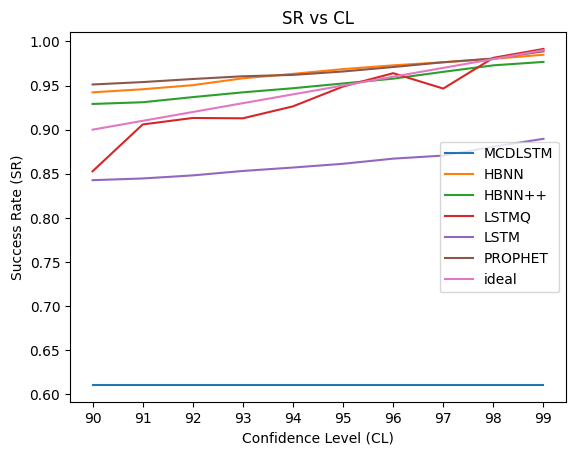

In [43]:
fig, ax = plt.subplots()
ax.set_title("SR vs CL")
ax.set_xlabel("Confidence Level (CL)")
ax.set_ylabel("Success Rate (SR)")
for model in models:
    df_model = df_success[df_success["model"] == model]
    sr_values = df_model["SR"].values
    qos_values = df_model["qos"].values
    ax.plot(qos_values, sr_values)
y_values = [float(v)/100 for v in qos_values]
x_values = qos_values
ax.plot(x_values, y_values)
models.extend(["ideal"])
ax.legend(models)
plt.show()

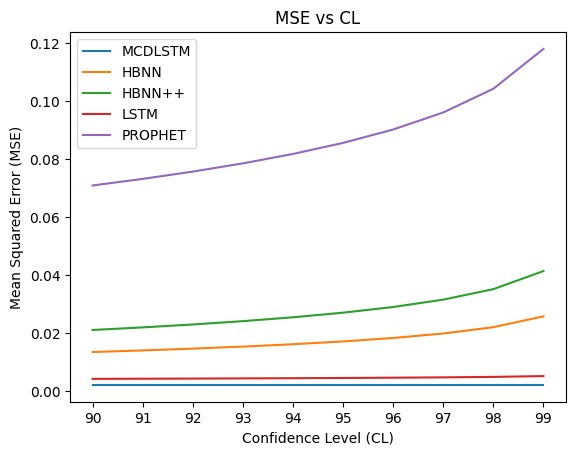

In [44]:
models = ["MCDLSTM", "HBNN", "HBNN++", "LSTM", "PROPHET"]
fig, ax = plt.subplots()
ax.set_title("MSE vs CL")
ax.set_xlabel("Confidence Level (CL)")
ax.set_ylabel("Mean Squared Error (MSE)")
for model in models:
    df_model = df_accuracy[df_accuracy["model"] == model]
    mse_values = df_model["mse"].values
    qos_values = df_model["qos"].values
    ax.plot(qos_values, mse_values)
ax.legend(models)
plt.show()

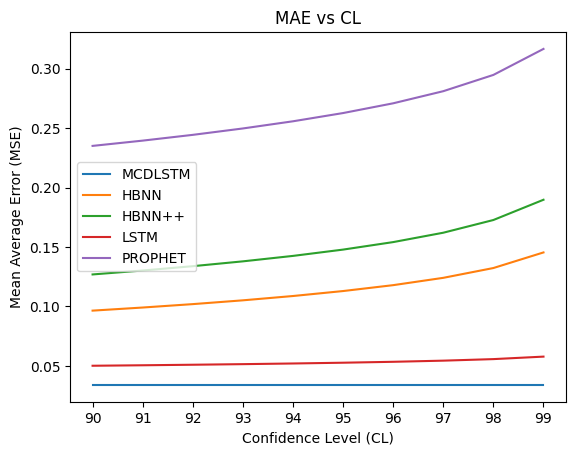

In [47]:
plt.show()
models = ["MCDLSTM", "HBNN", "HBNN++", "LSTM", "PROPHET"]
fig, ax = plt.subplots()
ax.set_title("MAE vs CL")
ax.set_xlabel("Confidence Level (CL)")
ax.set_ylabel("Mean Average Error (MSE)")
for model in models:
    df_model = df_accuracy[df_accuracy["model"] == model]
    mae_values = df_model["mae"].values
    qos_values = df_model["qos"].values
    ax.plot(qos_values, mae_values)
ax.legend(models)
plt.show()

In [247]:
# sr_value = sum(df_results.ub_95>df_results.true_gpu)/df_results.shape[0]
# print("SR", sr_value)

# up_value = sum((df_results.ub_95<df_results.true_norm_gpu)*(df_results.true_norm_gpu-df_results.ub_95))/sum((df_results.ub_95<df_results.true_norm_gpu)*df_results.true_norm_gpu)
# up_value = sum((df_results.ub_95<df_results.true_norm_gpu)*(df_results.true_norm_gpu-df_results.ub_95))/sum(df_results.ub_95<df_results.true_norm_gpu)

# up_value = sum((df_results.ub_95<df_results.true_norm_gpu)*((df_results.true_norm_gpu-df_results.ub_95)))/sum(df_results.true_norm_gpu)
# print("UP", up_value)

# op_value = sum((df_results.ub_95>df_results.true_norm_gpu)*(df_results.ub_95-df_results.true_norm_gpu))/sum((df_results.ub_95>df_results.true_norm_gpu)*df_results.true_norm_gpu)

# op_value = sum((df_results.ub_95>df_results.true_norm_gpu)*(df_results.ub_95-df_results.true_norm_gpu))/sum(df_results.ub_95>df_results.true_norm_gpu)

# op_value = sum((df_results.ub_95>df_results.true_norm_gpu)*((df_results.ub_95-df_results.true_norm_gpu)))/sum(df_results.true_norm_gpu)
# print("OP", op_value)

<h2>Baselines</h2>

a. Running exactly the required number of GPUs that would be specified by our schedulers acting as an oracle. Will have minimal energy use, and a 100% success rate.

b. Always running the maximum number of GPUs acting as a dummy predictor. Will have maximal energy use, and a 100% success rate.

c. Always running the GPUs that were specified by the oracle for the previous time window.

In [57]:
# define the costs (expressed in Watt)
unit_cost = 1
cost_on_5_mins = 1

n_total_gpus = 6742 # total number of GPUs

<h2>Energy scenario 1</h2>

All GPU machines have the same computational power and they consume the same amount of energy.

The scenario has no memory (no GPU state transitions), i.e. the energy consumption is calculated independently from the previous GPUs states.

In [66]:
energy_baseline_a = hbnn_results["true_n_gpu"].values.sum()*cost_on_5_mins
energy_baseline_b = n_total_gpus*len(hbnn_results)*cost_on_5_mins
baseline_c_values = list(hbnn_results["true_n_gpu"].values[:-1])
baseline_c_values.insert(baseline_c_values[0], 0) # because I do not know the first value
energy_baseline_c = np.sum(baseline_c_values)*cost_on_5_mins

In [67]:
models = {"MCD": monte_results,
          "HBNN": hbnn_results,
          "HBNN++": flbnn_results,
          "LSTMQ": lstmq_results,
          "LSTM": lstm_results,
          "PROPHET": prophet_results,
          }
tot_energy_column = []
target_column = []
savings_column = []
model_column = []
for target in target_qos:
    target_column.append(target)
    tot_energy_column.append(energy_baseline_a)
    model_column.append("oracle")
    savings_column.append(100 - round(energy_baseline_a/energy_baseline_b*100, 2))

    target_column.append(target)
    tot_energy_column.append(energy_baseline_b)
    model_column.append("naive")
    savings_column.append(100 - round(energy_baseline_b/energy_baseline_b*100, 2))

    target_column.append(target)
    tot_energy_column.append(energy_baseline_c)
    model_column.append("baseline_c")
    savings_column.append(100 - round(energy_baseline_c/energy_baseline_b*100, 2))

    for model in models:
        target_column.append(target)
        model_column.append(model)

        en_value = models[model][f"pred_n_gpu_{target}"].values.sum()*cost_on_5_mins
        tot_energy_column.append(en_value)
        savings_column.append(100 - round(en_value/energy_baseline_b*100, 2))

d = {"qos": target_column,
     "model": model_column,
     "tot_energy": tot_energy_column,
     "savings (%)": savings_column
     }
df_scenario_1 = pd.DataFrame(data=d)
df_scenario_1.to_csv("scenarios/scenario_1_results.csv", index=False)

<h2>Energy scenario 3</h2>

All GPU machines have the same computational power and they consume the same amount of energy when ON.
At the beginning of the first time window all GPUs are ON. Then allocation starts based on the workload prediction and GPUs status are updated accordingly. There is a cost you pay in terms of turnin ON a GPU (in terms of a reduced workload capacity).

In [262]:
def calculate_consumption(n_gpu_predicted, history, fixed_cost_run, fixed_cost_switch):
    if n_gpu_predicted > history:
        transition_cost = (n_gpu_predicted - history)*fixed_cost_switch
    else:
        transition_cost = 0
    return transition_cost + n_gpu_predicted*fixed_cost_run

In [263]:
models = {"MCD": monte_results,
          "HBNN": hbnn_results,
          "HBNN++": flbnn_results,
          "LSTMQ": lstmq_results,
          # "LSTM": lstm_results
          }

In [264]:
total_cost = 0
gpu_history = hbnn_results["true_n_gpu"].values
for i, n_gpu in enumerate(gpu_history):
    if i == 0:
        total_cost += n_gpu
        continue
    total_cost += calculate_consumption(n_gpu, gpu_history[i-1], cost_on_5_mins, turn_on_cost)
energy_baseline_a = total_cost
energy_baseline_b = n_total_gpus*len(hbnn_results)*cost_on_5_mins + turn_on_cost*n_total_gpus

In [265]:
# TODO baseline c

In [266]:
tot_energy_column = []
target_column = []
savings_column = []
model_column = []
for target in target_qos:
    target_column.append(target)
    tot_energy_column.append(energy_baseline_a)
    model_column.append("baseline_a")
    savings_column.append(100 - round(energy_baseline_a/energy_baseline_b*100, 2))

    target_column.append(target)
    tot_energy_column.append(energy_baseline_b)
    model_column.append("baseline_b")
    savings_column.append(100 - round(energy_baseline_b/energy_baseline_b*100, 2))

    for model in models:
        target_column.append(target)
        model_column.append(model)

        total_cost = 0
        gpu_history = models[model][f"pred_n_gpu_{target}"].values
        for i, n_gpu in enumerate(gpu_history):
            if i == 0:
                total_cost += n_gpu*cost_on_5_mins
                continue
            total_cost += calculate_consumption(n_gpu, gpu_history[i-1], cost_on_5_mins, turn_on_cost)
        tot_energy_column.append(total_cost)
        savings_column.append(100 - round(total_cost/energy_baseline_b*100, 2))

d = {"qos": target_column,
     "model": model_column,
     "tot_energy": tot_energy_column,
     "% energy savings": savings_column
     }
df_scenario_3 = pd.DataFrame(data=d)
df_scenario_3.to_csv("scenario_3.csv")

<h2>Energy scenario 2</h2>

All GPUs are of different characteristics. At the beginning of each time window, all GPUs are OFF.

In [274]:
gpus_specs = {"P100": (1596, float(scaler.inverse_transform(np.array(0.000404575892857).reshape(-1,1))), 0.0208),
              "T4": (994, float(scaler.inverse_transform(np.array(0.00056640625).reshape(-1,1))), 0.0058),
              "V100": (1912, float(scaler.inverse_transform(np.array(0.000283203125).reshape(-1,1))), 0.0233),
              "MISC": (2240, float(scaler.inverse_transform(np.array(0.000361596009975).reshape(-1,1))), 0.0208),
              }
for spec in gpus_specs:
    print(f"{spec}: {gpus_specs[spec]}")

P100: (1596, 10659485.301714368, 0.0208)
T4: (994, 10662963.714422604, 0.0058)
V100: (1912, 10656876.492183197, 0.0233)
MISC: (2240, 10658561.4838754, 0.0208)


In [119]:
def allocate_resources(w_demand: float,
                       df_stat: pd.DataFrame
                       ) -> float:
    df_allocation = df_stat.copy()
    wd_rem = w_demand
    cost = 0
    while wd_rem > 0:
        # if a single GPU can satisfy the remaining work, we choose the cheapest one.
        if wd_rem < max(df_allocation.w):
            df_allocation = df_allocation[df_allocation["w"] > wd_rem]
            df_allocation.sort_values(by='cost', inplace=True)
            cost += df_allocation.cost.head(1).values[0]
            break

        # Otherwise we select the most efficient
        wd_rem -= df_allocation.w.tail(1).values[0]
        cost += df_allocation.cost.tail(1).values[0]
        # remove the GPU used
        df_allocation.drop(df_allocation.tail(1).index,inplace=True) # drop last n rows
    return cost

In [141]:
# build dataframe of GPUs
w = [] # stores workload that GPUs can provide
e = [] # stores energy consumption
c = [] # stores energy cost to turn on GPUs
s = [] # stores the status of GPUs
g_name = [] # stores the name of the GPUs
for gpu_name in gpus_specs:
    w_value = gpus_specs[gpu_name][1]
    n_g = gpus_specs[gpu_name][0]
    e_g = gpus_specs[gpu_name][2]
    c_g = gpus_specs[gpu_name][2]*0.2
    g_name.extend([gpu_name for i in range(n_g)])
    w.extend([w_value for i in range(n_g)])
    e.extend([e_g for i in range(n_g)])
    c.extend([c_g for i in range(n_g)])
    s.extend([1 for i in range(n_g)])

d = {"gpu_name": g_name, 'w': w, 'e': e, 'c': c, 's': s}
df_gpus_status = pd.DataFrame(data=d)

# efficiency of GPU = workload provided / energy required
df_gpus_status['cost'] = df_gpus_status.e + df_gpus_status.s * df_gpus_status.c
df_gpus_status['eff'] = df_gpus_status.w/ df_gpus_status.cost

df_gpus_status = df_gpus_status.sort_values(by='eff')
print(df_gpus_status.head(2))

     gpu_name         w       e         c  s      cost       eff
3370     V100  0.000283  0.0233  0.005825  1  0.029125  0.009724
2868     V100  0.000283  0.0233  0.005825  1  0.029125  0.009724


In [142]:
# pred_workloads = {"baseline_a": list(hbnn_results["true_norm_gpu"].values),
#                   "HBNN": list(hbnn_results["ub_95"].values),
#                   }

pred_workloads = {"baseline_a": hbnn_results["true_norm_gpu"].values[:50],
                  "baseline_b": [1.45 for i in range(len(hbnn_results))], # max possible workload
                  "HBNN": hbnn_results["ub_95"].values[:50],
                  "MCD": monte_results["ub_95"].values[:50],
                  "HBNN++": flbnn_results["ub_95"].values[:50],
                  "LSTMQ": lstmq_results["ub_95"].values[:50],
                  "LSTM": lstm_results["ub_95"].values[:50],
                  }
print(f"{datetime.datetime.now()} -- BEGIN!")
scenario_2_costs = {}
for model in pred_workloads:
    demands = pred_workloads[model]
    tot_costs = [allocate_resources(demand, df_gpus_status) for demand in demands]
    scenario_2_costs[model] = np.sum(tot_costs)
    print(f"{datetime.datetime.now()} -- Done with model {model}!")
print(f"{datetime.datetime.now()} -- END!")

2023-06-23 17:26:25.239993 -- BEGIN!
2023-06-23 17:27:57.800369 -- Done with model baseline_a!


KeyboardInterrupt: 

In [ ]:
model_column = [model for model in scenario_2_costs]
energy_value = [100 - round(scenario_2_costs[model]/scenario_2_costs["baseline_b"]*100, 2) for model in scenario_2_costs]
d = {"model": model_column, "% energy savings": energy_value}
scenario_2_costs = pd.DataFrame(data=d)
scenario_2_costs

In [123]:
scenario_2_costs

{'baseline_a': 2317.0266000000797}

In [61]:
hbnn_results.head(1)

,model,pred_gpu,pred_std,true_norm_gpu,true_gpu,true_n_gpu,ub_95,pred_n_gpu_95
0,HBNN,0.79237,0.058169,0.804885,2.918980e+07,3718,0.88805,4103


<h3>Plots scenario 2</h3>

In [184]:
df_scenarios_results = pd.read_csv("scenarios/scenario_2_results.csv")
df_success = pd.read_csv("success_table.csv")
df_scenarios_results.columns

Index(['qos', 'model', 'energy_cost'], dtype='object')

In [185]:
models = ["MCD", "HBNN", "HBNN++", "LSTM", "oracle", "LSTMQ"]
df_success['model'] = df_success['model'].str.replace('MCDLSTM','MCD')
all_qos = df_success["qos"].unique()
d = {"model": ["oracle" for i in range(len(all_qos))],
     "qos": all_qos,
     "SR": [1 for i in range(len(all_qos))],
     "UP": [0 for i in range(len(all_qos))],
     "OP": [0 for i in range(len(all_qos))]}
df_base_a = pd.DataFrame(data=d)
df_success = pd.concat([df_success, df_base_a], ignore_index=True, axis=0)
df_success.reset_index(inplace=True, drop=True)

In [186]:
scenarios_results = {}
for qos in df_scenarios_results.qos.unique():
    df_scen = df_scenarios_results[df_scenarios_results["qos"] == qos].copy()
    max_cost = float(df_scen[df_scen["model"] == "baseline_b"]["energy_cost"])
    df_scen["savings (%)"] = df_scen.apply(lambda row: 100 - row["energy_cost"]/max_cost*100, axis=1)
    scenarios_results[qos] = df_scen

In [187]:
qos_values = []
savings_values = []
model_values = []
succ_values = []
op_values = []
up_values = []
for qos in scenarios_results:
    df_scen = scenarios_results[qos]
    df_scen = df_scen[df_scen["model"].isin(models)].copy()
    df_scen.sort_values(by="model",axis=0, inplace=True)
    df_succ = df_success[df_success["qos"] == qos]
    df_succ.sort_values(by="model",axis=0, inplace=True)

    savings_values.extend(df_scen["savings (%)"].values)
    qos_values.extend(df_scen["qos"].values)
    model_values.extend(df_scen["model"].values)
    succ_values.extend(df_succ["SR"].values)
    op_values.extend(df_succ["OP"].values)
    up_values.extend(df_succ["UP"].values)
d = {"qos": qos_values,
     "model": model_values,
     "savings": savings_values,
     "SR": succ_values,
     "OP": op_values,
     "UP": up_values,
     }
df_plot = pd.DataFrame(data=d)

/home/diego/miniconda3/envs/workloadpred/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [188]:
df_plot[df_plot["model"] == "baseline_a"]

,qos,model,savings,SR,OP,UP


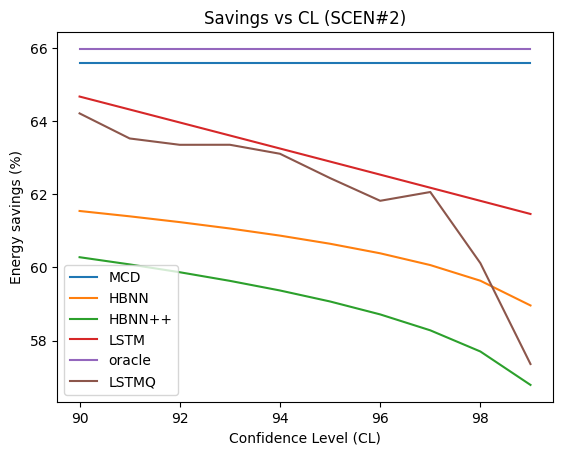

In [189]:
# build plot
fig, ax = plt.subplots()
ax.set_title("Savings vs CL (SCEN#2)")
ax.set_xlabel("Confidence Level (CL)")
ax.set_ylabel("Energy savings (%)")
for model in models:
    df_model = df_plot[df_plot["model"] == model]
    qos_values = df_model.qos
    savings_values = df_model.savings
    ax.plot(qos_values, savings_values)

ax.legend(models)
plt.show()

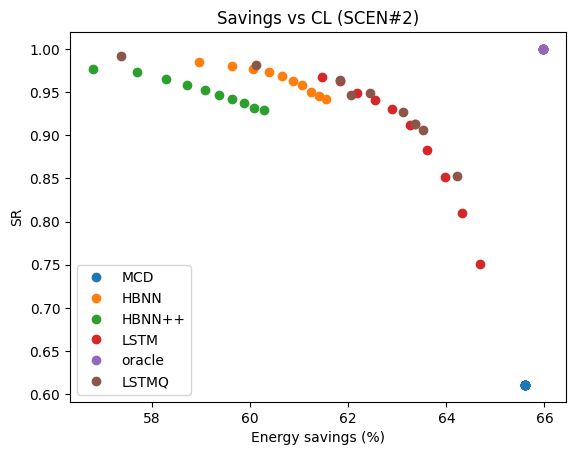

In [190]:
# build plot
fig, ax = plt.subplots()
ax.set_title("Savings vs CL (SCEN#2)")
ax.set_xlabel("Energy savings (%)")
ax.set_ylabel("SR")
for model in models:
    df_model = df_plot[df_plot["model"] == model].copy()
    df_model.sort_values(by="qos", ascending=True, inplace=True)
    qos_values = df_model.qos
    savings_values = df_model.savings
    succ_values = df_model.SR
    ax.plot(savings_values, succ_values, 'o', label=model)

ax.legend()
plt.show()

In [183]:
df_model

,qos,model,savings,SR,OP,UP
3,90,LSTMQ,64.216061,0.852827,0.049754,0.005663
9,91,LSTMQ,63.529880,0.905887,0.064502,0.003653
15,92,LSTMQ,63.356478,0.913246,0.068938,0.003390
21,93,LSTMQ,63.357544,0.912858,0.068951,0.003396
27,94,LSTMQ,63.111352,0.926414,0.074018,0.002787
33,95,LSTMQ,62.445154,0.948877,0.089509,0.001843
39,96,LSTMQ,61.824393,0.963981,0.104600,0.001254
45,97,LSTMQ,62.064599,0.946553,0.101040,0.002268
51,98,LSTMQ,60.117658,0.981410,0.146825,0.000741
57,99,LSTMQ,57.357722,0.991479,0.213358,0.000223


In [181]:
df_plot[df_plot["model"] == "HBNN"]

,qos,model,savings,SR,OP,UP
0,90,HBNN,61.545640,0.942293,0.114437,0.002518
6,91,HBNN,61.399475,0.945778,0.117808,0.002314
12,92,HBNN,61.240835,0.950426,0.121489,0.002111
18,93,HBNN,61.066385,0.958172,0.125561,0.001913
24,94,HBNN,60.871485,0.963207,0.130146,0.001728
30,95,HBNN,60.648834,0.968629,0.135403,0.001545
36,96,HBNN,60.387465,0.972889,0.141604,0.001356
42,97,HBNN,60.065409,0.976375,0.149267,0.001162
48,98,HBNN,59.636986,0.980248,0.159493,0.000944
54,99,HBNN,58.960563,0.984895,0.175684,0.000674


In [173]:
df_success[df_success["model"] == "HBNN"]

,model,qos,SR,UP,OP
10,HBNN,90,0.942293,0.002518,0.114437
11,HBNN,91,0.945778,0.002314,0.117808
12,HBNN,92,0.950426,0.002111,0.121489
13,HBNN,93,0.958172,0.001913,0.125561
14,HBNN,94,0.963207,0.001728,0.130146
15,HBNN,95,0.968629,0.001545,0.135403
16,HBNN,96,0.972889,0.001356,0.141604
17,HBNN,97,0.976375,0.001162,0.149267
18,HBNN,98,0.980248,0.000944,0.159493
19,HBNN,99,0.984895,0.000674,0.175684


hdsahfsh

In [ ]:
models = {"MCD": monte_results,
          "HBNN": hbnn_results,
          # "HBNN++": flbnn_results,
          # "LSTMQ": lstmq_results,
          # "LSTM": lstm_results,
          # "PROPHET": prophet_results,
          }
tot_energy_column = []
target_column = []
savings_column = []
model_column = []
for target in target_qos:
    target_column.append(target)
    tot_energy_column.append(energy_baseline_a)
    model_column.append("oracle")
    savings_column.append(100 - round(energy_baseline_a/energy_baseline_b*100, 2))

    target_column.append(target)
    tot_energy_column.append(energy_baseline_b)
    model_column.append("naive")
    savings_column.append(100 - round(energy_baseline_b/energy_baseline_b*100, 2))

    target_column.append(target)
    tot_energy_column.append(energy_baseline_c)
    model_column.append("baseline_c")
    savings_column.append(100 - round(energy_baseline_c/energy_baseline_b*100, 2))

    for model in models:
        target_column.append(target)
        model_column.append(model)

        en_value = models[model][f"pred_n_gpu_{target}"].values.sum()*cost_on_5_mins
        tot_energy_column.append(en_value)
        savings_column.append(100 - round(en_value/energy_baseline_b*100, 2))